In [1]:
import networkx as nx
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from math import comb
import os

In [2]:
def extract_subgraph_by_type(G, interaction_type):
    # Create a subgraph that only contains edges of the specified interaction type
    edges_of_type = [(u, v) for u, v, d in G.edges(data=True) if interaction_type in d['type']]
    # Create a subgraph with those edges
    subgraph = G.edge_subgraph(edges_of_type).copy()  # Copy is necessary to make it an independent graph
    return subgraph
    
# Function to compute intra-group edges for cliques of size c
def compute_h_c_i(c):
    h_c_i = []
    for i in range(c + 1):
        red_edges = comb(i, 2)  # Red-red edges
        blue_edges = comb(c - i, 2)  # Blue-blue edges
        h_c_i.append(red_edges + blue_edges)
    return h_c_i

# Function to compute the expected values of red nodes and homophily
def expected_values(theta1, theta2, h_c_i, c):
    max_exponent = max(theta1 * i + theta2 * h_c_i[i] for i in range(c + 1))  # Find the maximum exponent value
    Z = partition_function(theta1, theta2, h_c_i, c, max_exponent)
    F = [np.exp(theta1 * i + theta2 * h_c_i[i] - max_exponent) / Z for i in range(c + 1)]  # Subtract max_exponent
    expected_red_nodes = sum(i * F[i] for i in range(c + 1)) / c
    expected_homophily = sum(h_c_i[i] * F[i] for i in range(c + 1))
    return expected_red_nodes, expected_homophily

# Updated partition function to handle max_exponent
def partition_function(theta1, theta2, h_c_i, c, max_exponent=0):
    Z = sum(np.exp(theta1 * i + theta2 * h_c_i[i] - max_exponent) for i in range(c + 1))  # Subtract max_exponent
    return Z

# Function to compute the expected values of red nodes and homophily
#def expected_values(theta1, theta2, h_c_i, c):
#    Z = partition_function(theta1, theta2, h_c_i, c)
#    F = [np.exp(theta1 * i + theta2 * h_c_i[i]) / Z for i in range(c + 1)]
#    expected_red_nodes = sum(i * F[i] for i in range(c + 1)) / c
#    expected_homophily = sum(h_c_i[i] * F[i] for i in range(c + 1))
#    return expected_red_nodes, expected_homophily

# Objective function for optimization
def objective(params, N_r, h_c, h_c_i, c):
    theta1, theta2 = params
    expected_red_nodes, expected_homophily = expected_values(theta1, theta2, h_c_i, c)
    return (expected_red_nodes - N_r) ** 2 + (expected_homophily - h_c) ** 2

# Function to compute the partition function Z
#def partition_function(theta1, theta2, h_c_i, c):
#    Z = sum(np.exp(theta1 * i + theta2 * h_c_i[i]) for i in range(c + 1))
 #   return Z

# Function to compute maximum entropy distribution
def compute_max_entropy_distribution(theta1, theta2, h_c_i, c):
    Z = partition_function(theta1, theta2, h_c_i, c)
    F = [np.exp(theta1 * i + theta2 * h_c_i[i]) / Z for i in range(c + 1)]
    return F

# Function to compute clique homophily distributions
def compute_clique_homophily_distributions(subgraphs_by_size, cliques_by_size, n_r, n_b):
    distributions = {}
    homophily_values = {}

    for size, subgraph in subgraphs_by_size.items():
        F = [0] * (size + 1)
        for clique in cliques_by_size[size]:
            red_node_count = sum(1 for node in clique if subgraph.nodes[node].get('color') == 'red')
            F[red_node_count] += 1
        total_cliques = sum(F)
        if total_cliques > 0:
            F = [count / total_cliques for count in F]
        distributions[size] = (F, total_cliques)

        h_c = compute_homophily_value(F, size, n_r, n_b)
        homophily_values[size] = max(-1, min(1, h_c))

    return distributions, homophily_values

# Function to compute the homophily value
def compute_homophily_value(F, c, n_r, n_b):
    h_c = 0
    for i in range(c + 1):
        clique_homophily = (2 / (c * (c - 1))) * (i**2 - c * i + (c**2 - c) / 2)
        h_c_contribution = (clique_homophily - (n_r**2 + n_b**2)) / (1 - (n_r**2 + n_b**2))
        h_c += F[i] * h_c_contribution
    return h_c

# Plot histograms of cliques
def plot_clique_histograms(clique_sizes, filename="figs/clique_histograms.pdf"):
    plt.figure(figsize=(10, 3))
    plt.hist(clique_sizes, bins=range(1, max(clique_sizes) + 2), edgecolor='black', alpha=0.7)
    plt.xlabel('Clique Size')
    plt.ylabel('Frequency')
    plt.title('Histogram of Clique Sizes')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Plot homophily vs. clique size
def plot_homophily_vs_clique_size(clique_sizes_set, homophily_values, inferred_params, filename="figs/homophily_vs_clique_size.pdf"):
    plt.figure(figsize=(10, 3))
    clique_sizes = sorted(clique_sizes_set)
    homophily_values_list = [homophily_values[c] for c in clique_sizes]
    theta1_values = [inferred_params[c][0] for c in clique_sizes]
    theta2_values = [inferred_params[c][1] for c in clique_sizes]

    plt.plot(clique_sizes, homophily_values_list, label=r'$h_c$', marker='o', color='purple', linewidth=2.5)
    plt.xlabel('Clique Size')
    plt.ylabel('Homophily $h_c$')
    plt.title('Homophily vs Clique Size')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# Function to plot clique homophily distributions
def plot_clique_homophily_distributions(clique_sizes_set, distributions, homophily_values, inferred_params, filename="figs/clique_homophily_distribution.pdf"):
    fig = plt.figure(figsize=(18, 14))
    num_clique_sizes = len(clique_sizes_set)
    grid_size = int(np.ceil(np.sqrt(num_clique_sizes)))

    cmap = plt.get_cmap('Reds')
    
    for i, size in enumerate(np.sort(list(clique_sizes_set))):
        ax = fig.add_subplot(grid_size, grid_size, i + 1)
        F, total_cliques = distributions.get(size, ([], 0))
        h_c = homophily_values[size]
        x = np.arange(len(F))
        colors = [cmap(red_count / size) for red_count in x]

        ax.bar(x, F, color=colors, edgecolor='black')

        if size in inferred_params:
            theta1, theta2 = inferred_params[size]
            h_c_i = compute_h_c_i(size)
            F_max_entropy = compute_max_entropy_distribution(theta1, theta2, h_c_i, size)
            ax.plot(x, F_max_entropy, 'r--', linewidth=2.5)

        ax.text(0.5, 0.95, f'$G_{{{size}}}$\n{total_cliques} cliques\n$h_c={h_c:.2f}$',
                horizontalalignment='center', verticalalignment='top',
                transform=ax.transAxes, fontsize=14, bbox=dict(facecolor='white', alpha=0.3))
        
        ax.set_ylim(0, 1)
        ax.set_xlabel('Number of Red Nodes $i$', fontsize=14)

        # Show only the beginning, middle, and end values on the x-axis
        if len(x) > 2:
            ax.set_xticks([0, len(x)//2, len(x) - 1])
        else:
            ax.set_xticks(np.arange(0, max(x) + 1))

        if i % grid_size == 0:
            ax.set_ylabel('Proportion of Cliques $F$', fontsize=14)
        else:
            ax.set_yticklabels([])

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

def network_to_clique_plots(G, prefix='CPH'):
    # Ensure the directory 'figs' exists
    if not os.path.exists('figs'):
        os.makedirs('figs')
    hist_filename = os.path.join("figs/", prefix+"_histograms.pdf")
    homophily_filename = os.path.join("figs/", prefix+"_homophily_vs_clique_size.pdf")
    homophily_distribution_filename = os.path.join("figs/", prefix+"_clique_distribution.pdf")
    
    N = len(G)
    Nr = sum(1 for node, data in G.nodes(data=True) if data.get('color') == 'red')
    Nb = N - Nr
    n_r = Nr / N
    n_b = Nb / N
    
    print(f"{N} nodes")
    print(f"{n_r * 100:.2f}% red nodes and {n_b * 100:.2f}% blue nodes")
    
    # Find cliques
    maximal_cliques = list(nx.find_cliques(G))
    
    # Filter out cliques containing nodes not present in G
    maximal_cliques = [clique for clique in maximal_cliques if all(node in G.nodes for node in clique)]
    
    clique_sizes = [len(clique) for clique in maximal_cliques]
    clique_sizes_set = set(clique_sizes)
    
    plot_clique_histograms(clique_sizes, hist_filename)

    # Group cliques by size
    cliques_by_size = {size: [] for size in clique_sizes_set}
    for clique in maximal_cliques:
        clique_size = len(clique)
        cliques_by_size[clique_size].append(clique)

    # Create subgraphs for each clique size
    subgraphs_by_size = {}
    for size, cliques in cliques_by_size.items():
        subgraph = nx.Graph()
        for clique in cliques:
            subgraph.add_edges_from([(clique[i], clique[j]) for i in range(len(clique)) for j in range(i + 1, len(clique))])
            for node in clique:
                if node in G.nodes:  # Check if node exists in G
                    subgraph.nodes[node].update(G.nodes[node])
        subgraphs_by_size[size] = subgraph
    
    distributions, homophily_values = compute_clique_homophily_distributions(subgraphs_by_size, cliques_by_size, n_r, n_b)
    
    inferred_params = {}
    for c in np.sort(list(clique_sizes_set)):
        if c in cliques_by_size and len(cliques_by_size[c]) > 0:
            F, total_cliques = distributions[c]
            N_r_empirical = sum(i * F[i] for i in range(c + 1)) / c
            h_c_empirical = sum(compute_h_c_i(c)[i] * F[i] for i in range(c + 1))
            h_c_i = compute_h_c_i(c)
            result = minimize(objective, [0, 0], args=(N_r_empirical, h_c_empirical, h_c_i, c))
            inferred_params[c] = result.x
    
    plot_clique_homophily_distributions(clique_sizes_set, distributions, homophily_values, inferred_params, homophily_distribution_filename)
    plot_homophily_vs_clique_size(clique_sizes_set, homophily_values, inferred_params, homophily_filename)

In [3]:
file_name = '/scratch/cs/networks/data/copenhagen_study/static_network_with_gender_and_link_type.graphml'
# Load the network
g = nx.read_graphml(file_name)
print(len(g), len(g.edges()))

780 16305


Bluetooth network: 639 nodes, 12449 edges
Call network: 510 nodes, 584 edges
SMS network: 536 nodes, 649 edges
Facebook network: 744 nodes, 5865 edges

639 nodes
78.09% red nodes and 21.91% blue nodes


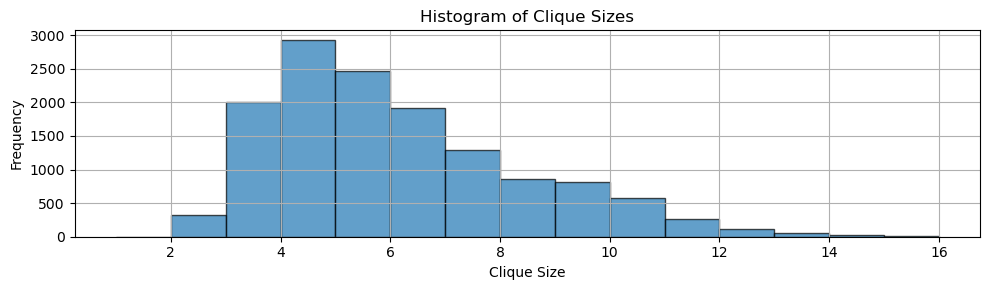

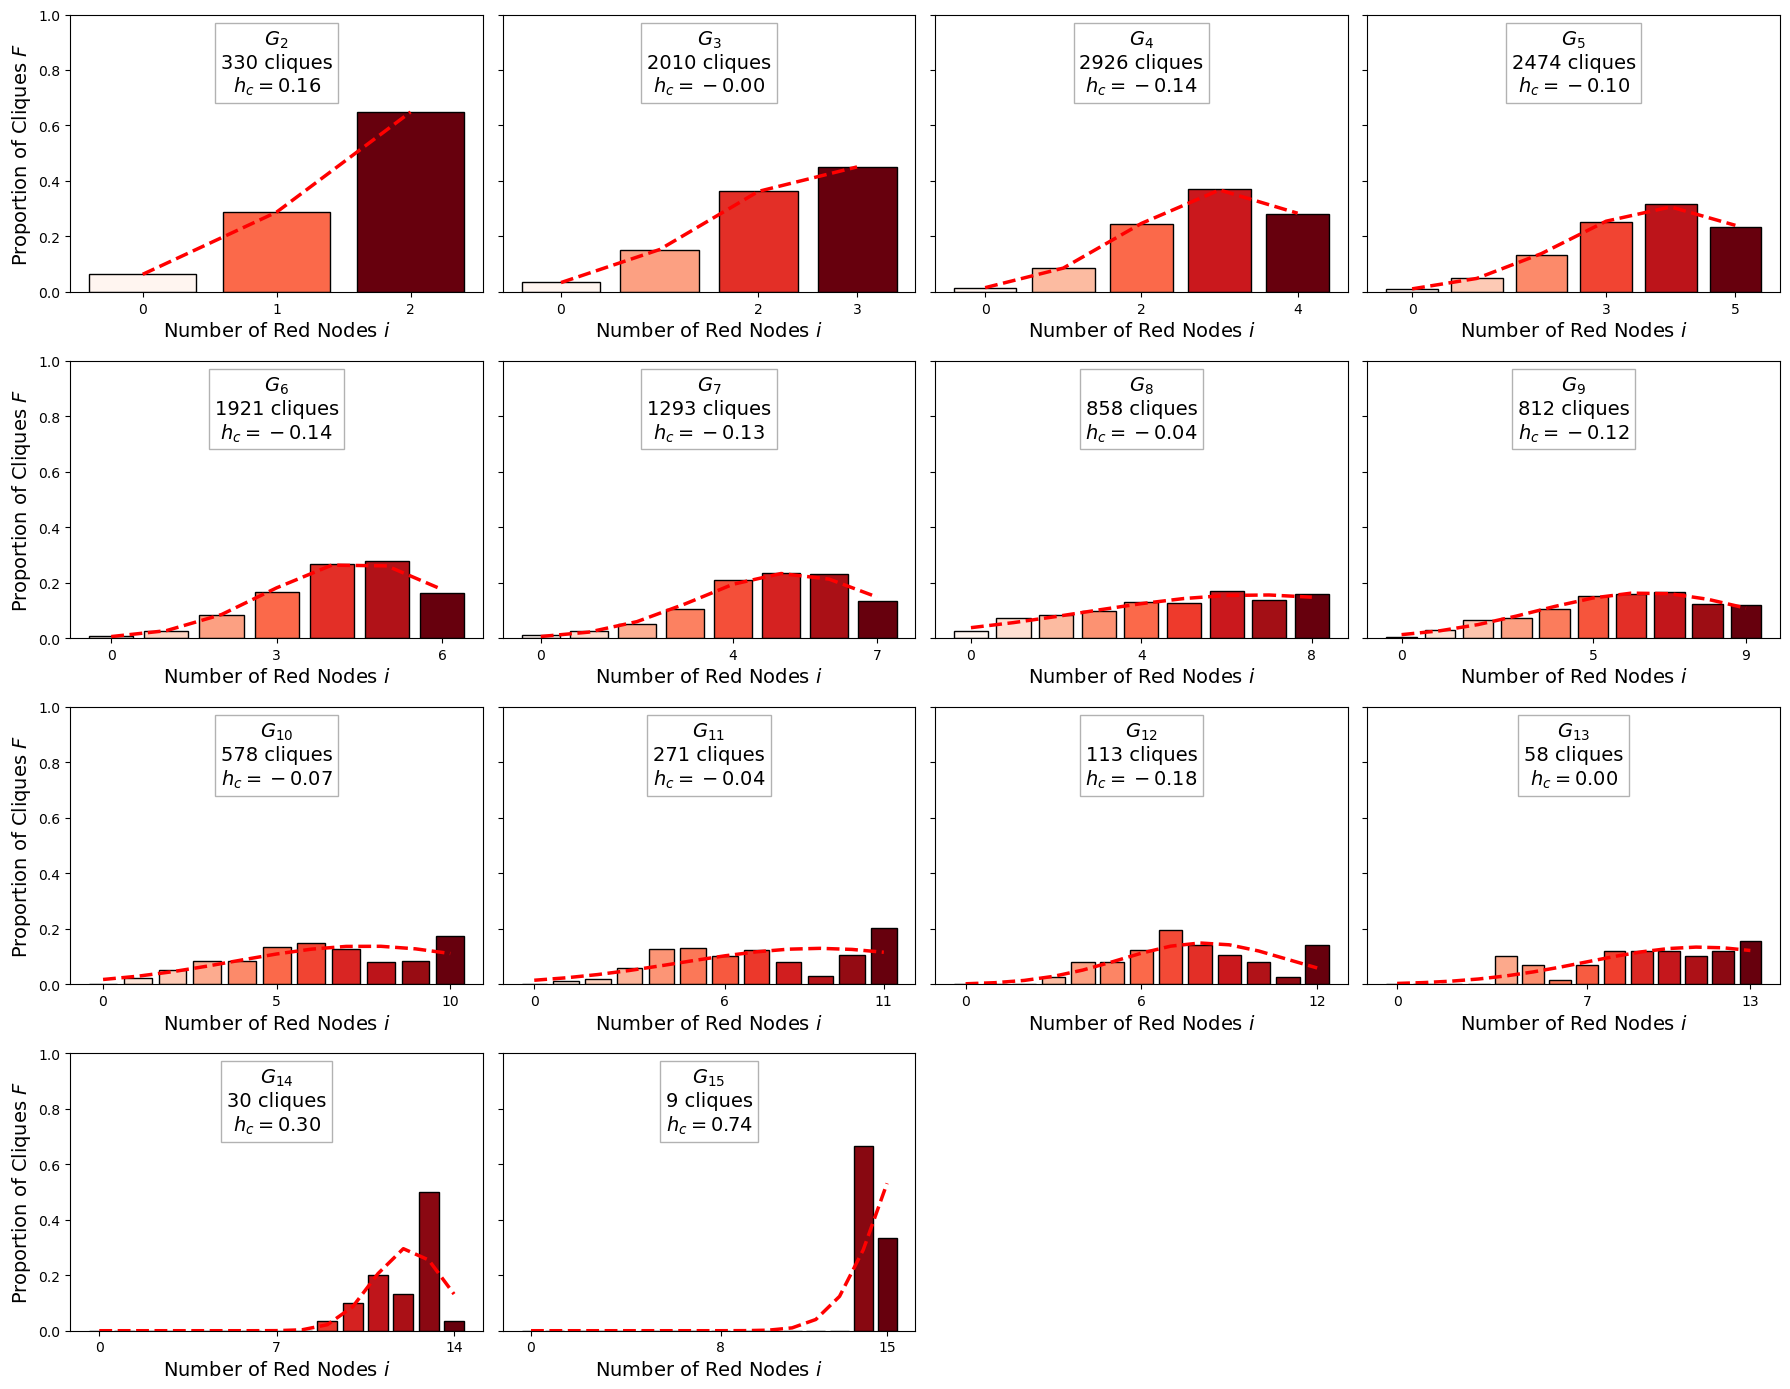

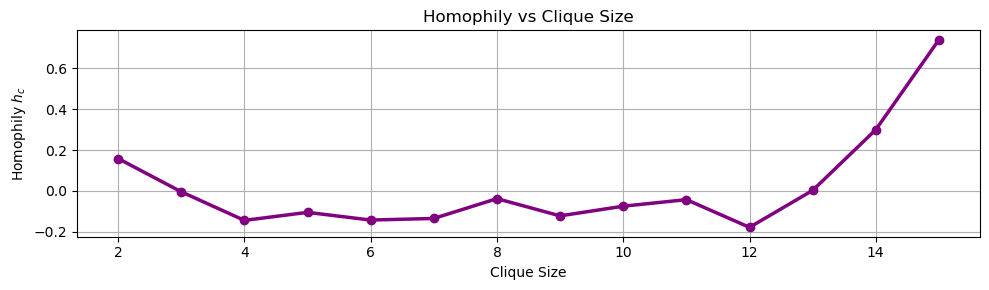

510 nodes
78.04% red nodes and 21.96% blue nodes


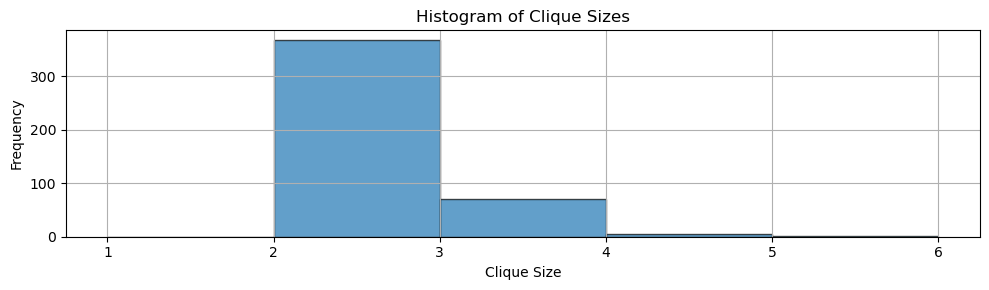

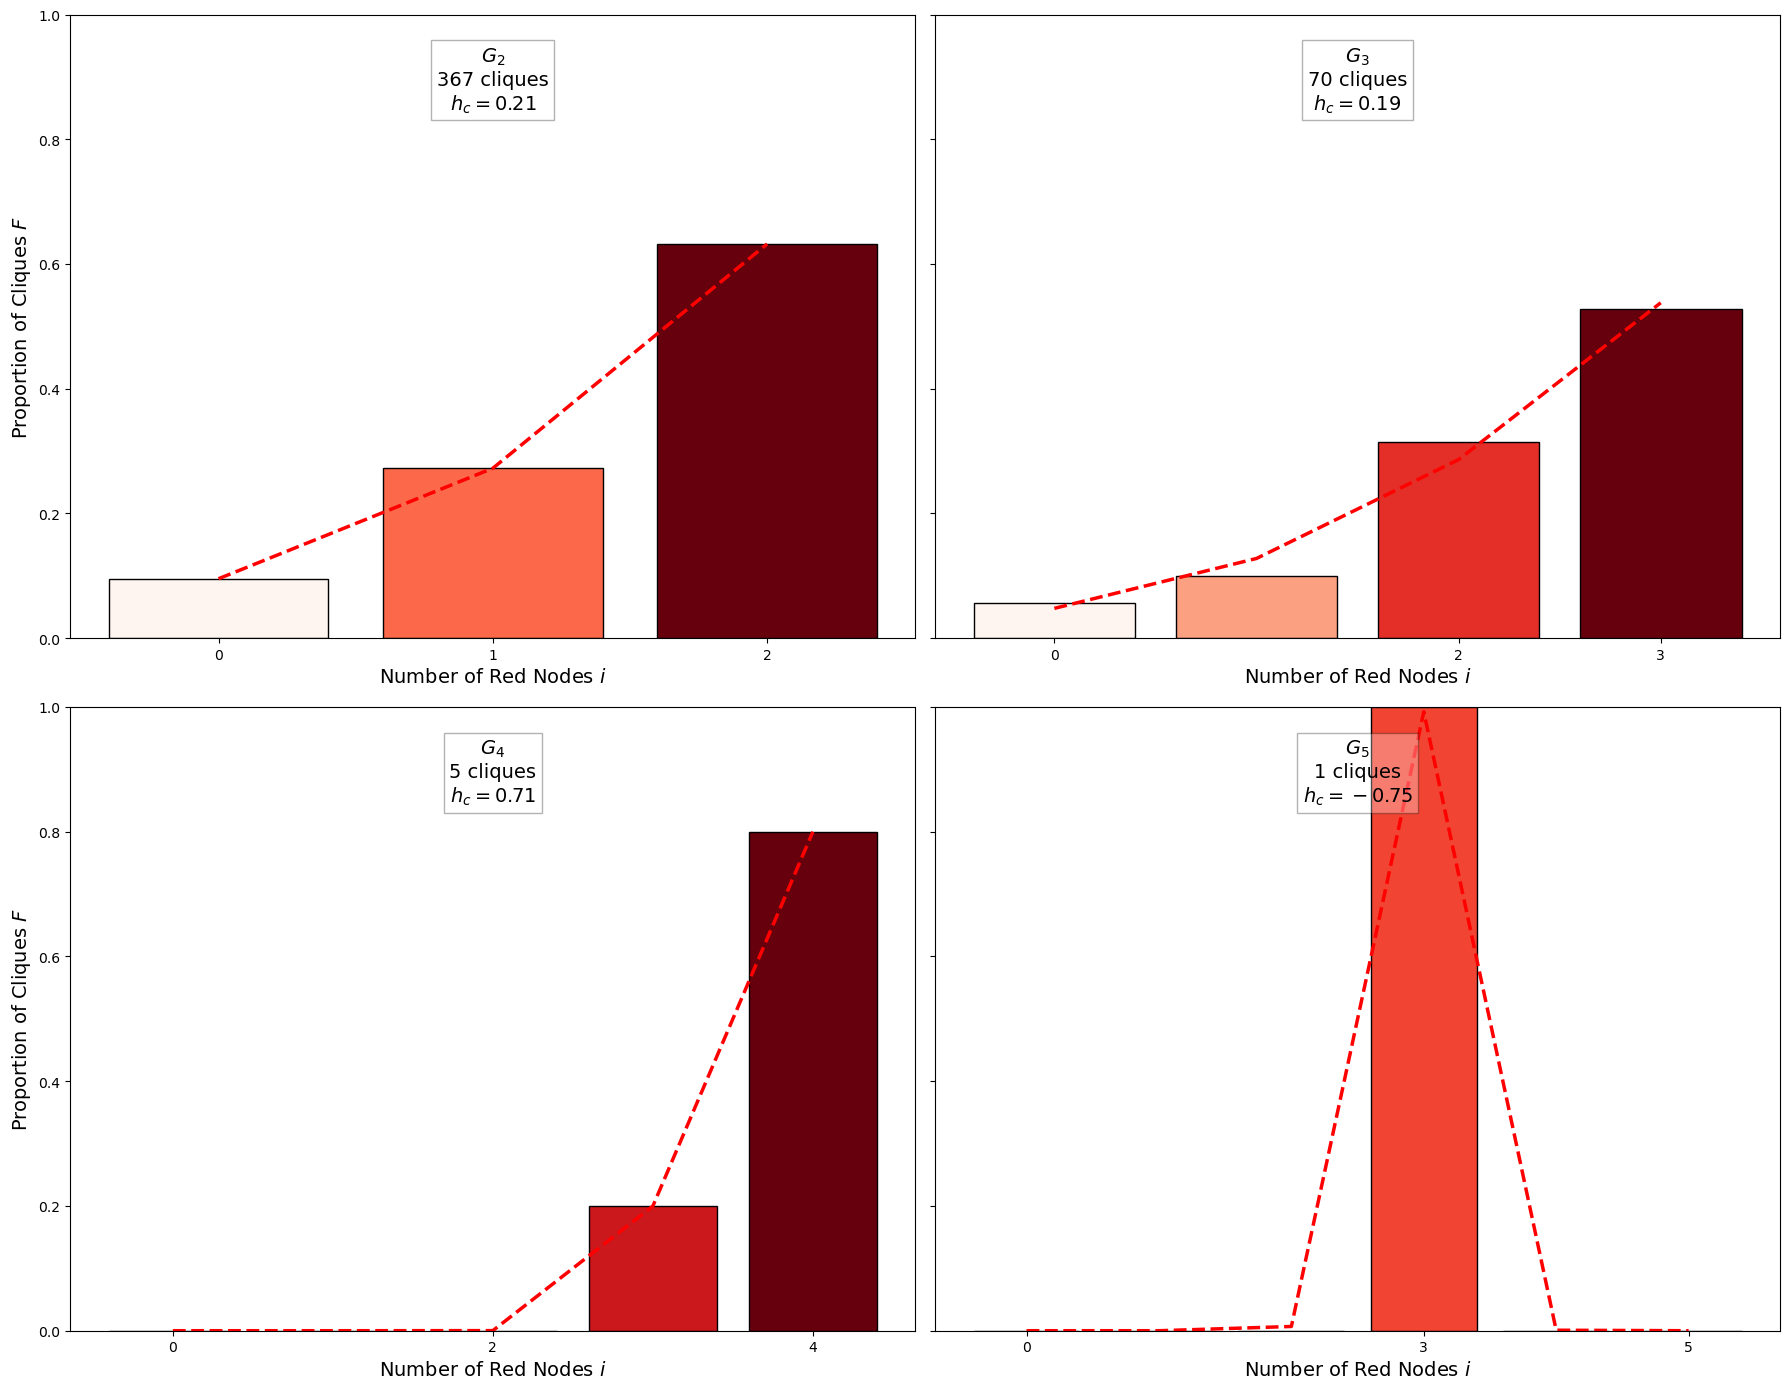

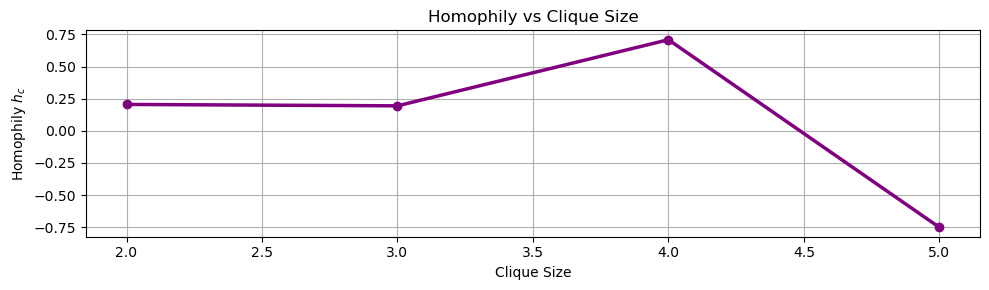

536 nodes
76.87% red nodes and 23.13% blue nodes


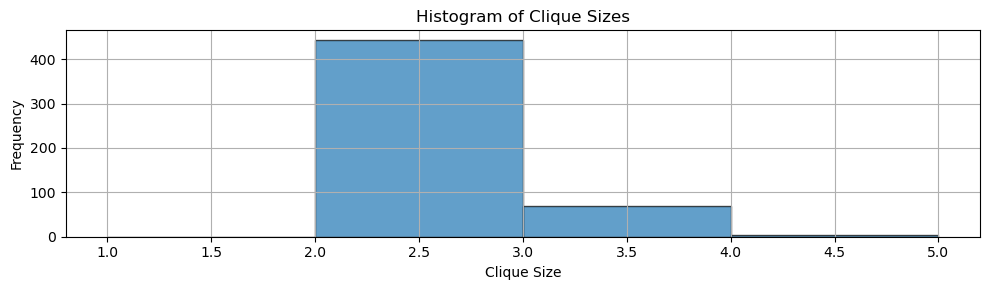

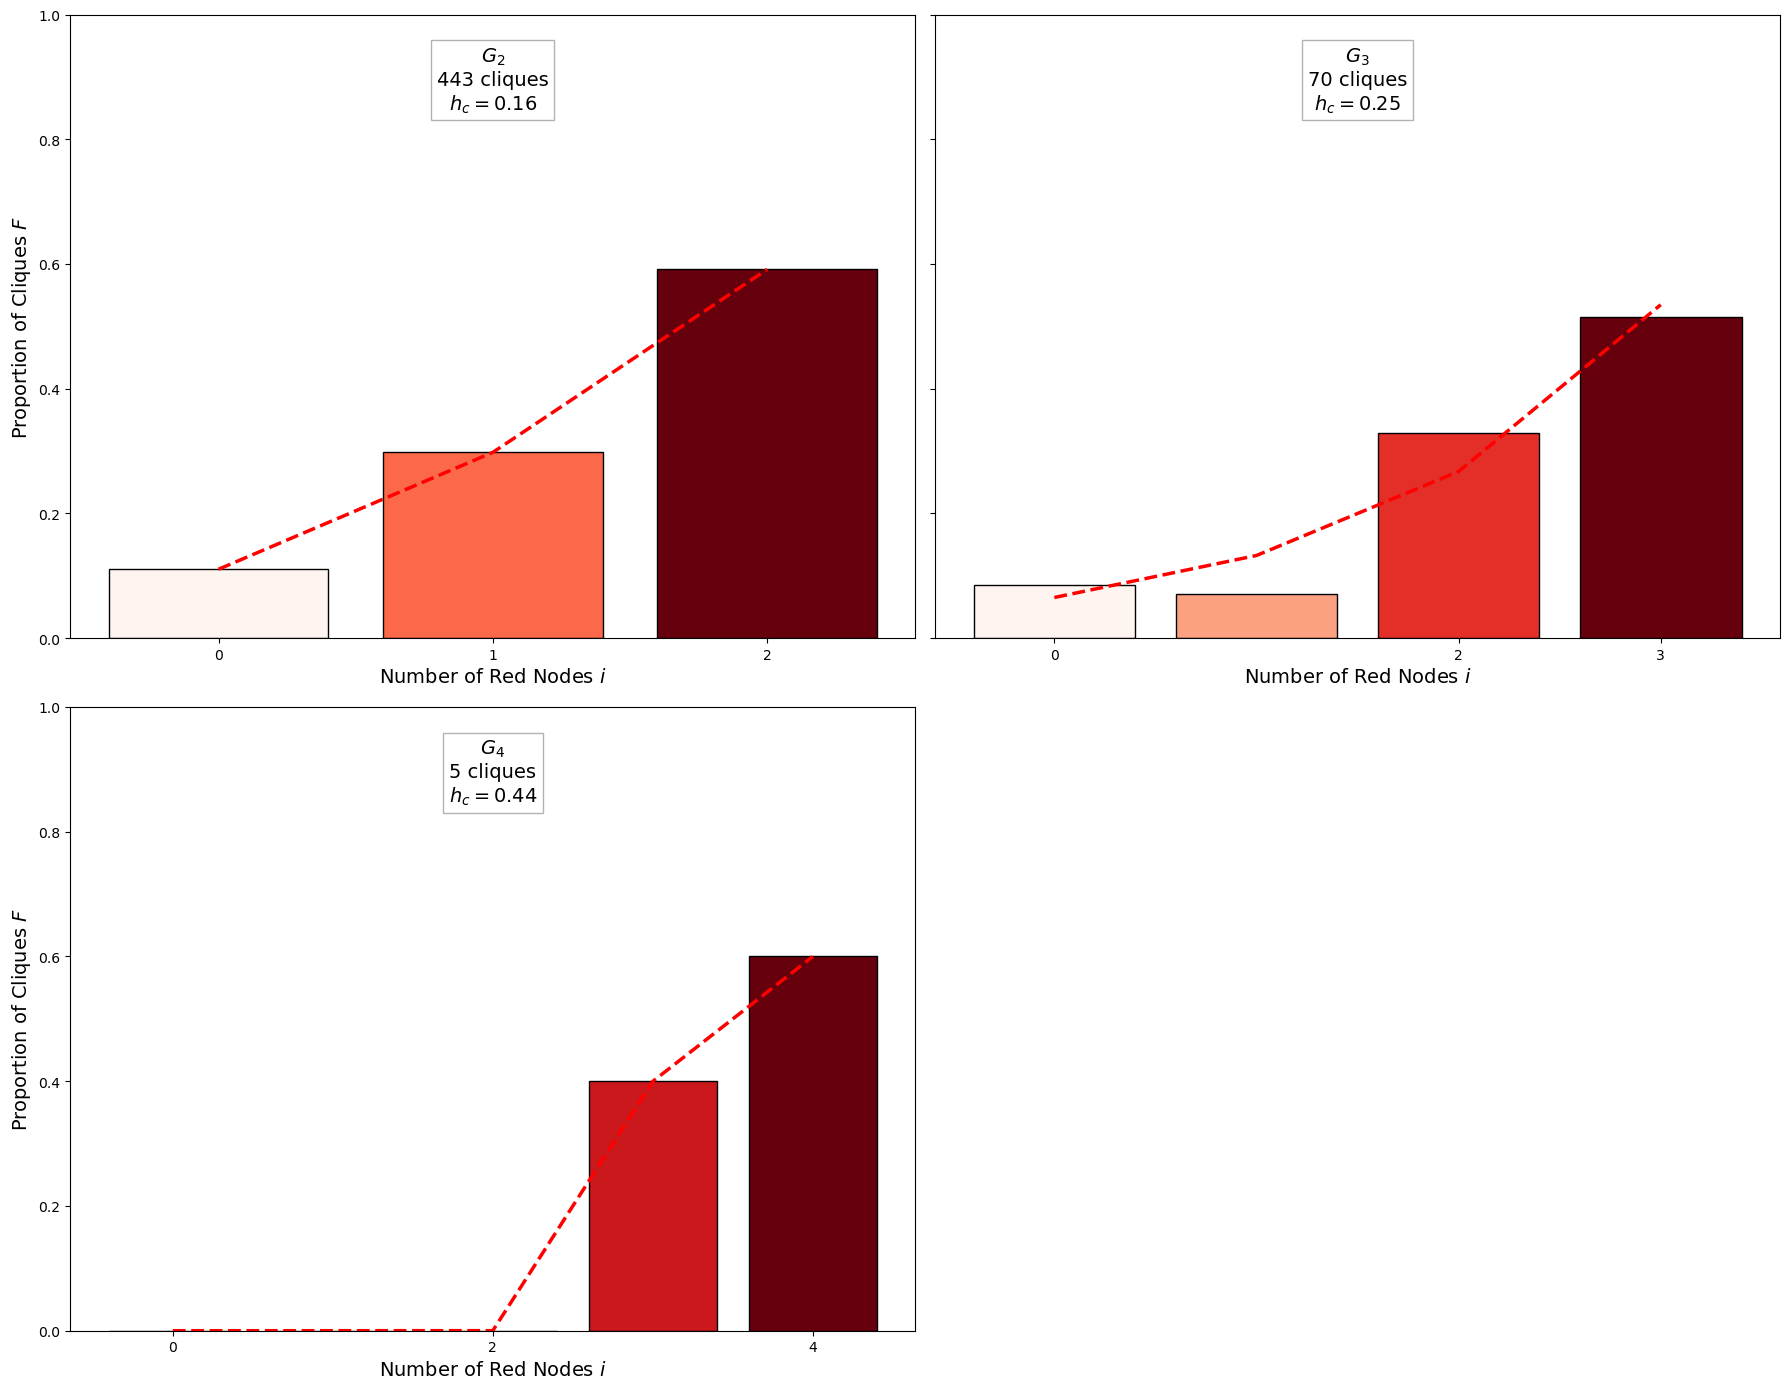

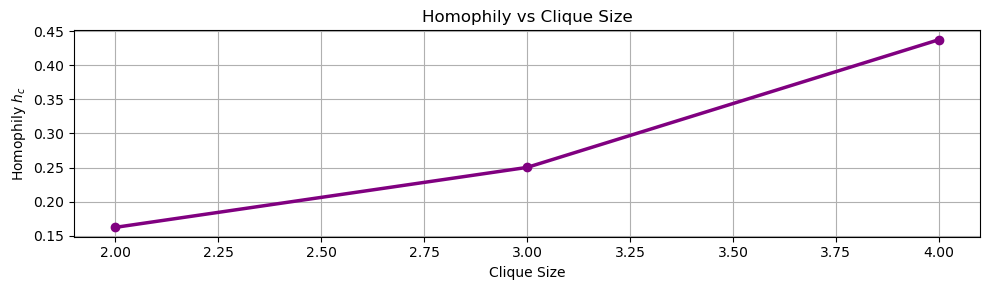

744 nodes
77.69% red nodes and 22.31% blue nodes


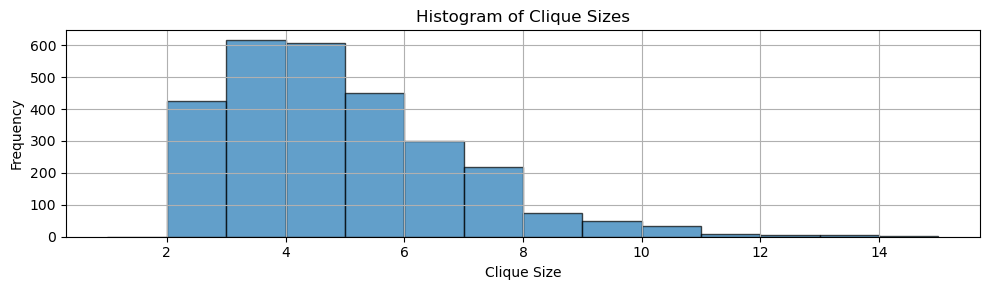

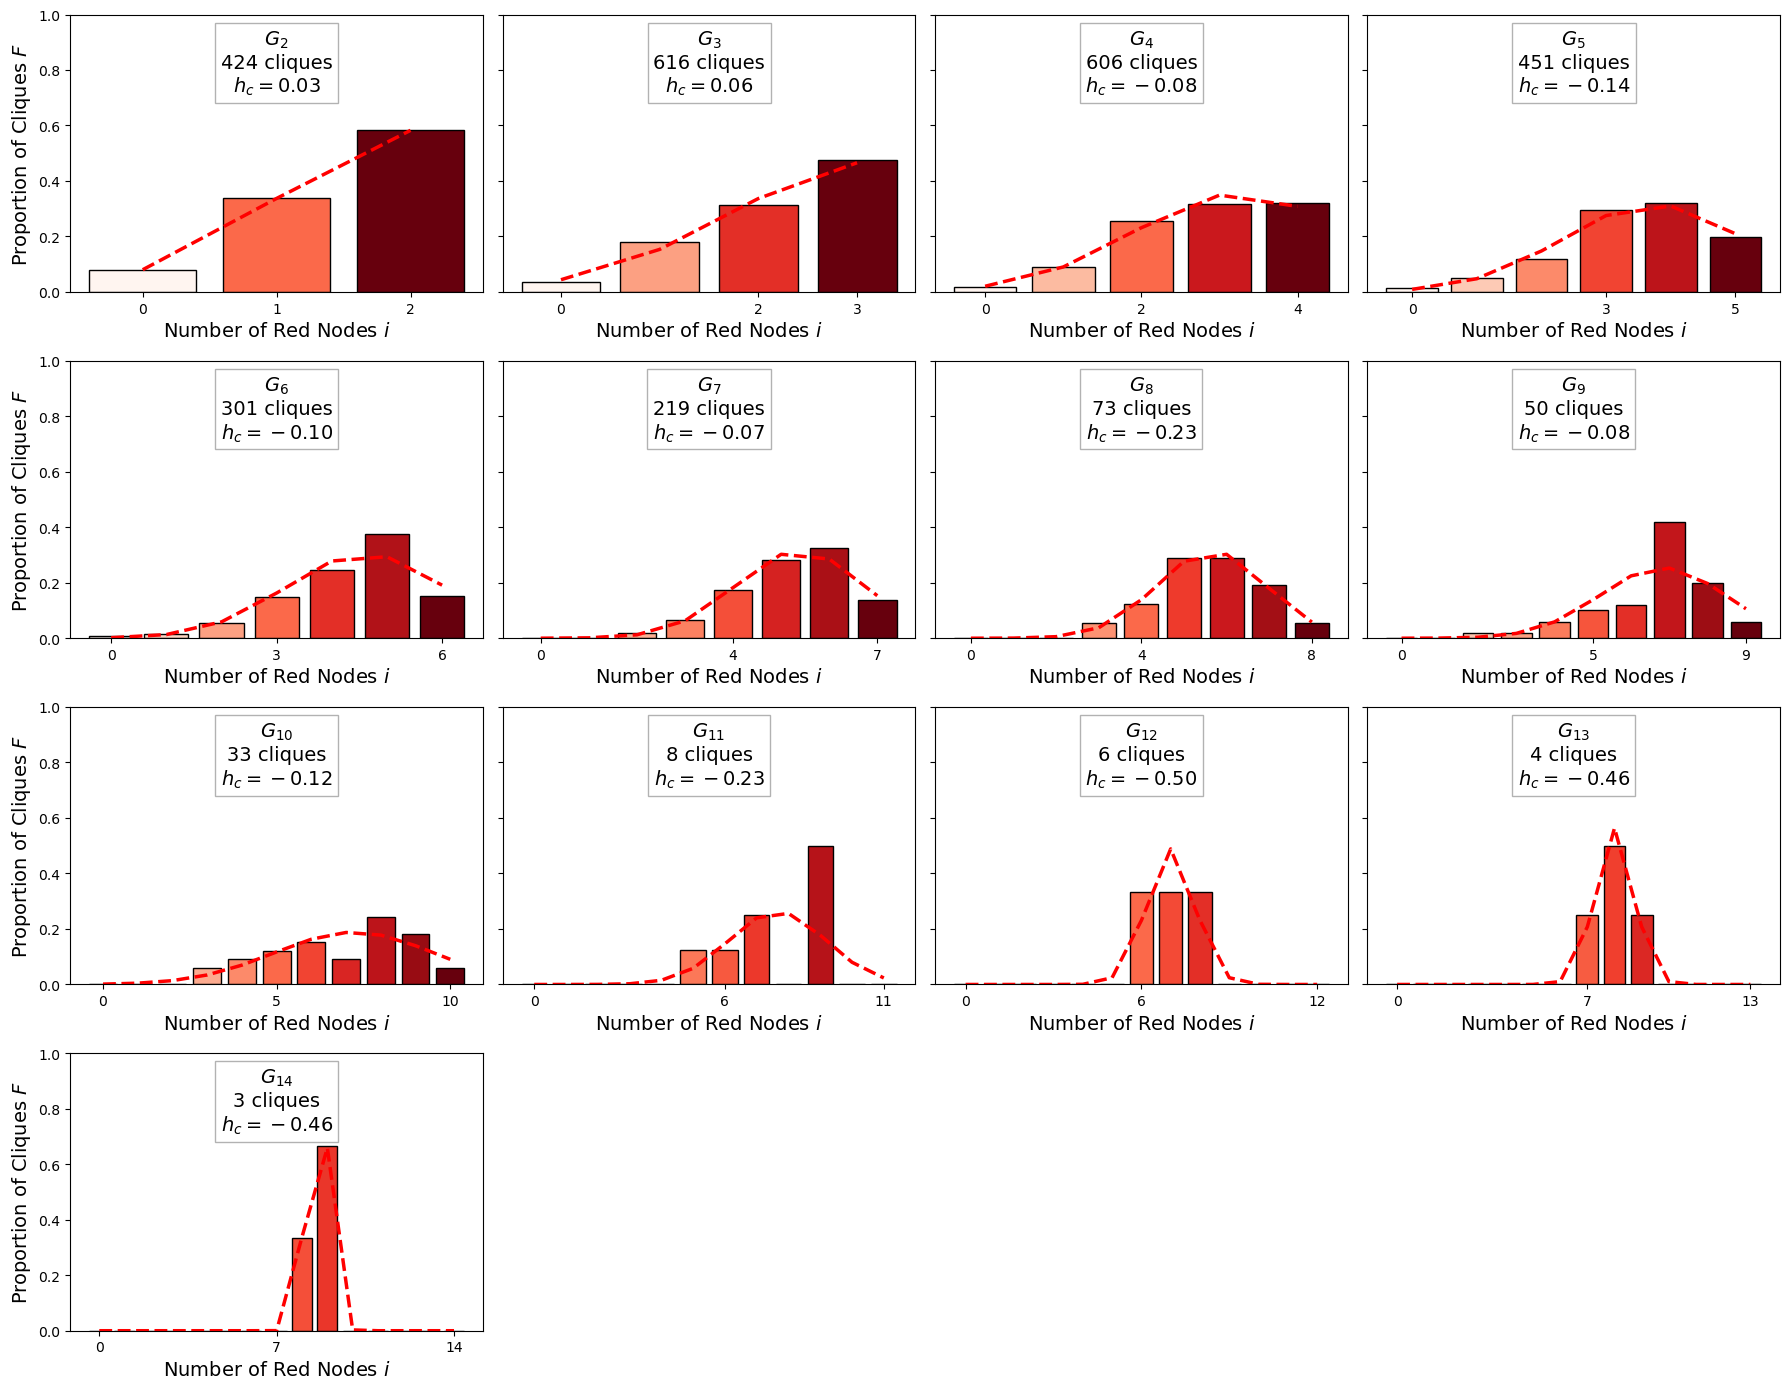

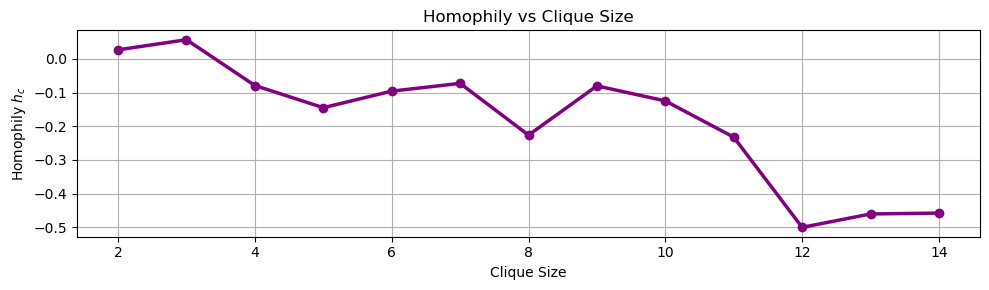

In [4]:
# Extract subgraphs based on link type
bluetooth_subgraph = extract_subgraph_by_type(g, 'Bluetooth')
call_subgraph = extract_subgraph_by_type(g, 'Call')
sms_subgraph = extract_subgraph_by_type(g, 'SMS')
facebook_subgraph = extract_subgraph_by_type(g, 'Facebook')

# Print summary for each subgraph
print(f"Bluetooth network: {bluetooth_subgraph.number_of_nodes()} nodes, {bluetooth_subgraph.number_of_edges()} edges")
print(f"Call network: {call_subgraph.number_of_nodes()} nodes, {call_subgraph.number_of_edges()} edges")
print(f"SMS network: {sms_subgraph.number_of_nodes()} nodes, {sms_subgraph.number_of_edges()} edges")
print(f"Facebook network: {facebook_subgraph.number_of_nodes()} nodes, {facebook_subgraph.number_of_edges()} edges")
print()
# Call the function to generate the plots
for idx, subb in enumerate([bluetooth_subgraph, call_subgraph, sms_subgraph, facebook_subgraph]):
    network_to_clique_plots(subb, str(idx))

779 nodes
78.05% red nodes and 21.95% blue nodes


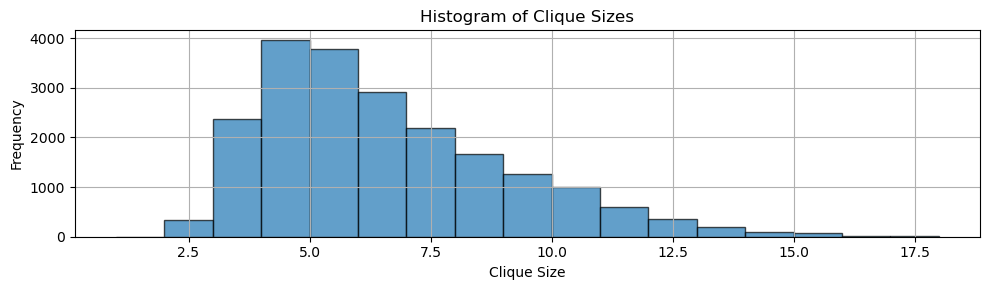

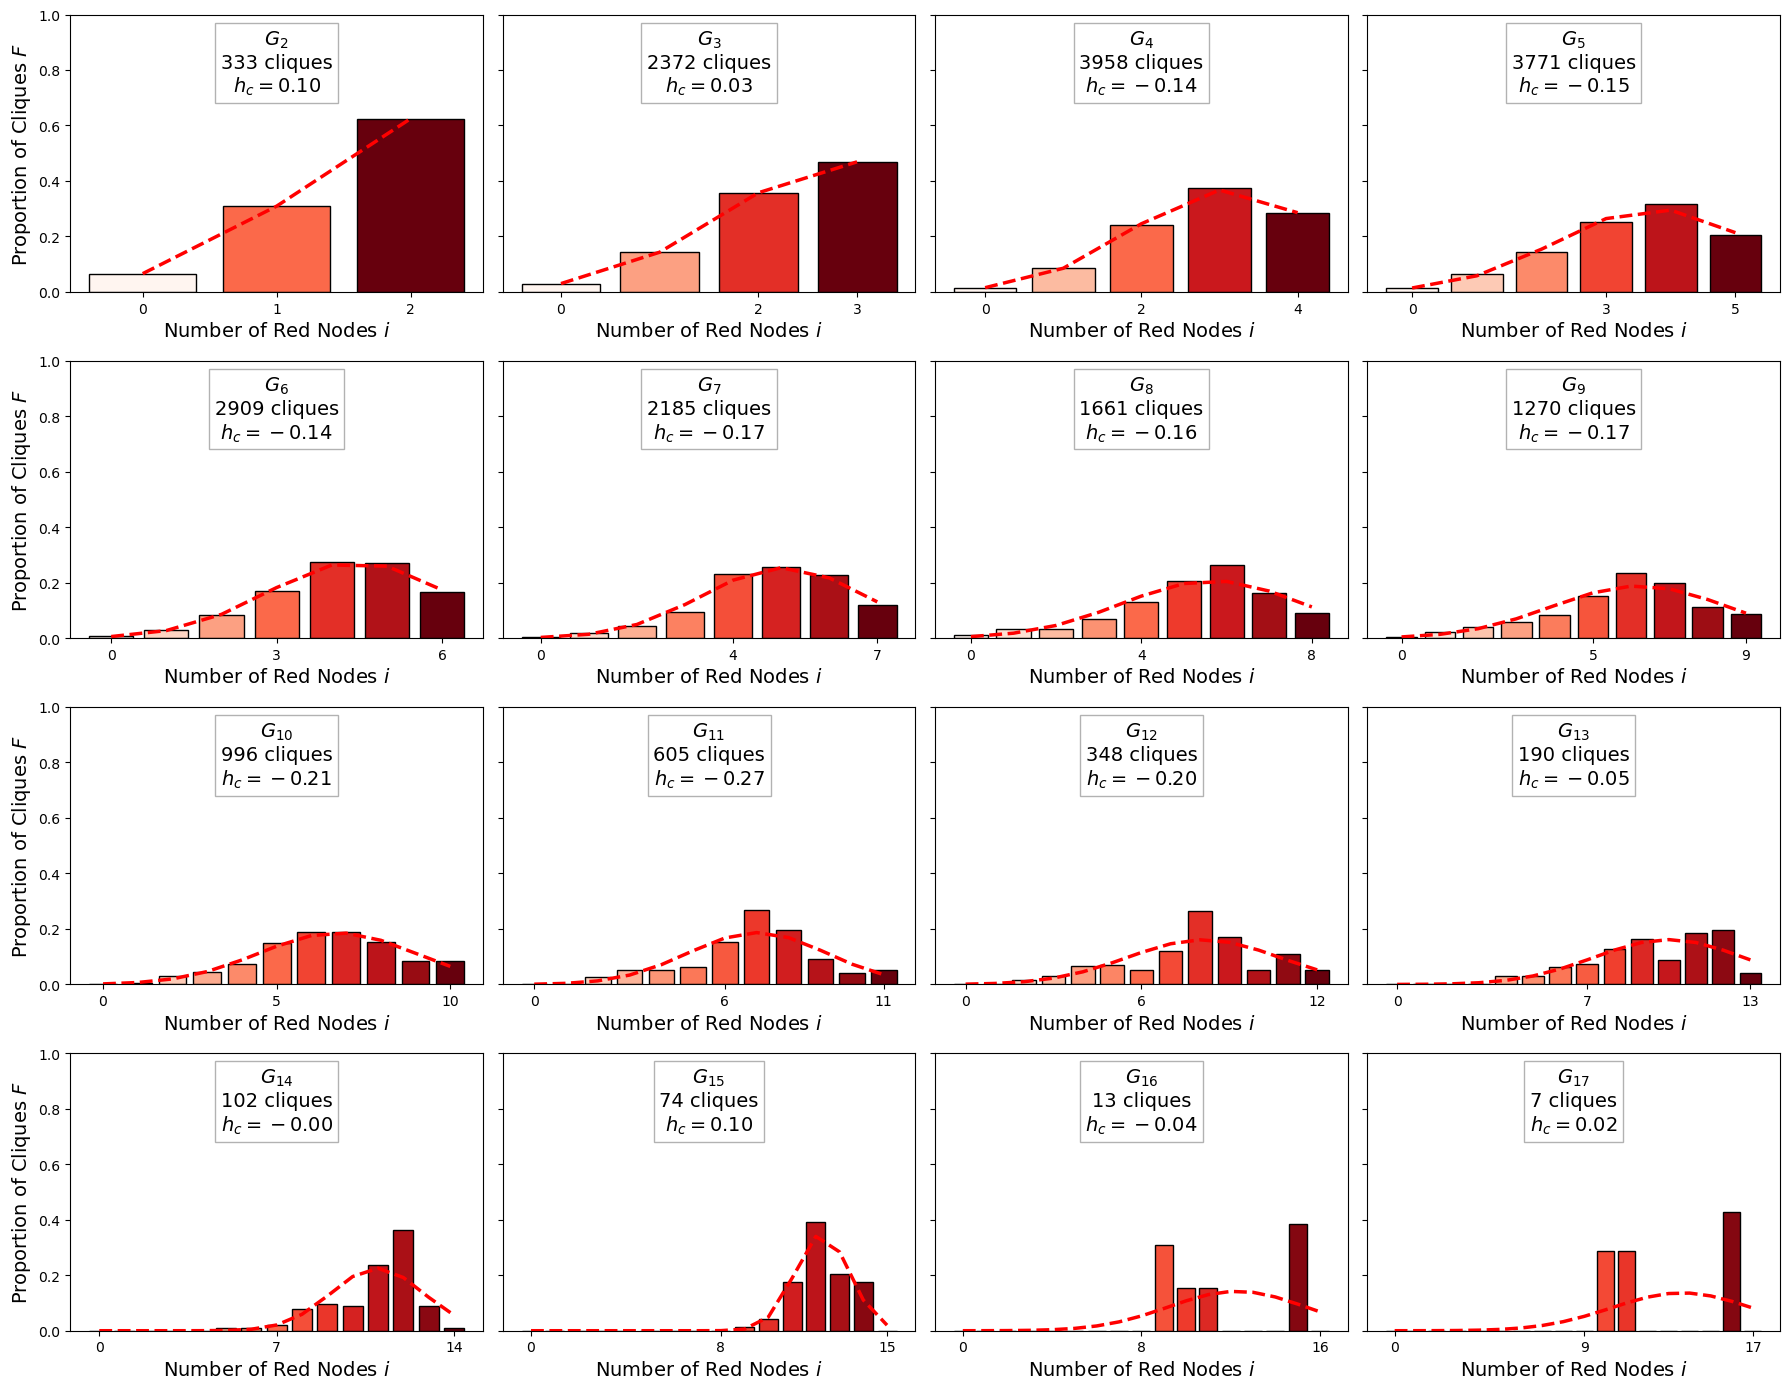

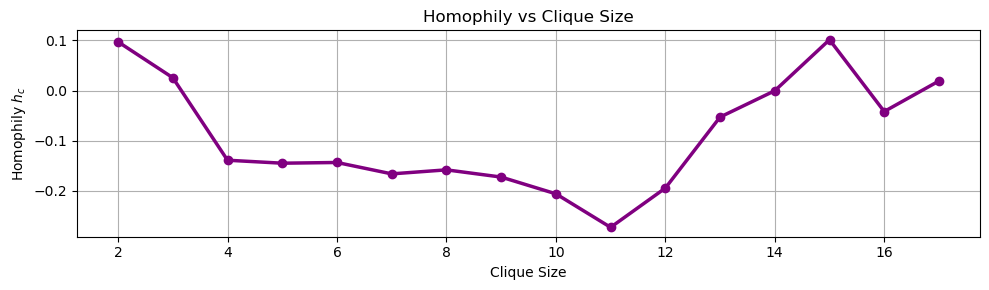

In [5]:
union = nx.compose(nx.compose(bluetooth_subgraph, call_subgraph), nx.compose(sms_subgraph, facebook_subgraph))
network_to_clique_plots(union)